# Homework 6: PyTorch and Pandas

name: Diana Liang

email: dliangia@umich.edu

I discussed Problem 1 with Isabella Gierlinger and Alyssa Wisk.
I discussed Problem 4.5 with Isabella Gierlinger.

This homework assignment took me 18 hours in total to complete. (Please help us to gauge the difficulty of the assignment.)

### Submission Instructions
Your homework solutions should be written entirely in this Jupyter notebook file. Once it contains your solutions, you should submit this notebook through Canvas. Before submitting, please make sure make sure __Cells->Run__ executes without errors; errors in your code cause problems for our auto-grader. Thus, even though we frequently ask you to check for errors in your functions, you should not include in your submission any examples of your functions actually raising those errors.

### Coding style
Please follow the [PEP8 guidelines](https://www.python.org/dev/peps/pep-0008/). The `pycodestyle_magic` package will remind you if you are not. To install it, run
```
pip install flake8 pycodestyle_magic
```
Once it is installed the following two Jupyter directives will enable syntax checking:

In [ ]:
%load_ext pycodestyle_magic
%pycodestyle_on

### Supplemental Data Files
Run the following code to download the supplemental files you will need to complete this homework:

In [1]:
from urllib import request
from os import path
from zipfile import ZipFile

url = "https://regier.stat.lsa.umich.edu/stats507/"
fn = "hw6data.zip"
if not path.exists(fn):
    data = request.urlopen(url + fn).read()
    with open(fn, 'wb') as fhand:
        fhand.write(data)
    with ZipFile(fn, 'r') as zipObj:
        zipObj.extractall()

## Problem 1: Building and training simple models with PyTorch (10 points)
In this problem, you'll use PyTorch to build the loss functions for a pair of commonly-used statistical models. In all cases, your answer should include variables `x` and `ytrue`, which will serve as the predictor (independent variable) and response (dependent variable), respectively. Please use `W` to denote a parameter that multiplies the predictor, and $b$ to denote a bias parameter (i.e., a parameter that is added).

1. __Logistic regression with a negative log-likelihood loss.__ In this model, which we discussed briefly in class, the binary variable $Y$ is distributed as a Bernoulli random variable with success parameter $\sigma(W^T X + b)$, where $\sigma(z) = (1+\exp(-z))^{-1}$ is the logistic function, and $X \in R^6$ is the predictor random variable, and $W \in R^6, b \in R$ are the model parameters. Derive the log-likelihood of $Y$, and write the PyTorch code that represents the negative log-likelihood loss function. __Hint:__ the loss should be a negative log-likelihood term, summed over all the observations.

In [1]:
import numpy as np
import torch
import math

In [182]:
def loss(W, X, b, ytrue):
    u = torch.mm(X, W)
    v = torch.add(u, b)
    y = torch.sigmoid(v)
    loss = -1*ytrue*torch.log(y)-(1-ytrue)*torch.log(1-y)
    return loss.sum()

2. __Estimating  parameters  in  logistic  regression.__ For this part you will use the follow four supplemental data files:
    - __logistic\_xtest.npy__: contains a 500-by-6 matrix whose rows are the independent variables (predictors) from the test set.
    - __logistic\_xtrain.npy__: contains a 2000-by-6 matrix whose rows are the independent variables (predictors) from the train set.
    - __logistic\_ytest.npy__: contains a binary 500-dimensional vector of dependent variables (responses) from the test set.
    - __logistic\_ytrain.npy__: contains a binary 2000-dimensional vector of dependent variables (responses) from the train set.
    
   The $i$-th row of the matrix in __logistic\_xtrain.npy__ is the predictor for the response in the $i$-th entry of the vector in __logistic\_ytrain.npy__, and analogously for the two test set files. Please include these files in your submission so that we can run your code without downloading them again. __Note:__ we didn't discuss reading numpy data from files. To load the files, you can simply call __xtrain = np.load('xtrain.npy')__ to read the data into the variable __xtrain__. __xtrain__ will be a Numpy array.

   Load the training data and use it to obtain estimates of $W$ and $b$ by minimizing the negative log-likelihood via gradient descent. __Another note:__ you'll have to play around with the learning rate and the number of steps. Two good ways to check if optimization is finding a good minimizer:
    - Try printing the training data loss before and after optimization.
    - Use the test data to validate your estimated parameters.

In [183]:
logistic_xtrain = torch.Tensor(np.load('logistic_xtrain.npy'))
logistic_ytrain = torch.Tensor(np.load('logistic_ytrain.npy'))
logistic_xtest = torch.Tensor(np.load('logistic_xtest.npy'))
logistic_ytest = torch.Tensor(np.load('logistic_ytest.npy'))

In [184]:
W = torch.ones(6, 1, dtype=torch.float, requires_grad=True)
b = torch.zeros(1, dtype=torch.float, requires_grad=True)
optimizer = torch.optim.SGD([W, b], lr=0.008)

In [185]:
for i in range(500):
    cost = loss(W, logistic_xtrain, b, logistic_ytrain)
    cost.backward()
    optimizer.step()
    W.grad.zero_()
    b.grad.zero_()

3. __Evaluating logistic regression on test data.__ Load the test data. What is the negative log-likelihood of your model on this test data? That is, what is the negative log-likelihood when you use your estimated parameters with the previously unseen test data?

In [187]:
test_likelihood = loss(W, logistic_xtest, b, logistic_ytest).item()

4. __Evaluating the estimated logistic parameters.__ The data was, in reality, generated with 
$$ W = (1,1,2,3,5,8),~~~~~~ b = -1. $$
    Write PyTorch expressions to compute the squared error between your estimated parameters and their true values. Evaluate the error in recovering $W$ and $b$ separately. What are the squared errors of these estimates? __Note:__ you need only evaluate the error of your final estimates, not at every step.

In [188]:
W_sqerr = ((W-torch.tensor([1,1,2,3,5,8]).view(6,1)).sum().item())**2
b_sqerr = ((b-torch.tensor([-1]).view(1,1)).sum().item())**2

5. For ease of grading, please make the variables from the above problems available in a dictionary called __results_logistic__. The dictionary should have keys __$W$, Wsqerr, $b$, bsqerr, log_lik_test__ corresponding to the evaluation of your estimate of $W$, $W$ squared error, $b$, $b$ squared error and the negative log-likelihood on the test set. For example, if my squared error for $W$ is stored in a torch.Tensor called __W_squared_error__, then the key __'Wsqerr'__ should have value __W_squared_error.item()__.

In [273]:
results_logistic = {'W': W, 'Wsqerr': W_sqerr,
                    'b': b, 'bsqerr': b_sqerr,
                    'log_lik_test': test_likelihood}

6. __Classification  of  normally  distributed  data.__ For this part you will use four Numpy __.npy__ files that contain train and test data generated from $K=3$ different classes. Each class $k \in \{1,2,3\}$ has an associated mean $\mu_k \in R$ and variance $\sigma^2_k \in R$, and all observations from a given class are i.i.d. $\mathcal{N}(\mu_k,\sigma^2_k)$. The four files are:
    - __normal_xtest.npy__: contains a 500-vector whose entries are the independent variables (predictors) from the test set.
    - __normal_xtrain.npy__: contains a 2000-vector whose entries are the independent variables (predictors) from the train set.
    - __normal_ytest.npy__: contains a 500-by-3 dimensional matrix whose rows are one-hot encodings of the class labels for the test set.
    - __normal_ytrain.npy__: contains a 2000-by-3 dimensional matrix whose rows are one-hot encodings of the class labels for the train set.
    
   The $i$-th entry of the vector in __normal_xtrain.npy__ is the observed random variable from class with label given by the $i$-th row of the matrix in __normal_ytrain.npy__, and analogously for the two test set files. Please include these files in your submission so that we can run your code without downloading them again.

   Load the training data and use it to obtain estimates of the vector of class means $\mu = (\mu_0,\mu_1,\mu_2)$ and variances $\sigma^2 = (\sigma^2_0, \sigma^2_1, \sigma^2_2)$ by minimizing the cross-entropy between the estimated normals and the one-hot encodings of the class labels (as we did in our softmax regression example in class). Please name the corresponding variables __mu__ and __sigma2__. This time, instead of using gradient descent, use Adagrad, supplied by Pytorch as the function __torch.optim.Adagrad__. Adagrad is a _stochastic gradient descent algorithm_, popular in machine learning. You can call this just like the gradient descent optimizer we used in class---just supply a learning rate. Documentation for the PyTorch implementation of Adagrad can be found here: https://pytorch.org/docs/stable/_modules/torch/optim/adagrad.html. See https://en.wikipedia.org/wiki/Stochastic_gradient_descent for more information about stochastic gradient descent and the Adagrad algorithm.
	
   __Note:__ you'll no longer be able to use the built-in logit cross-entropy that we used for training our models in lecture. Your cross-entropy for one observation should now look something like $ -\sum_k y'_k \log p_k,$ where $y'$ is the one-hot encoded vector and $p$ is the vector whose $k$-th entry is the (estimated) probability of the $k$-th observation given its class. __Another note:__ do not include any estimation of the mixing coefficients (i.e., the class priors) in your model. You only need to estimate three means and three variances, because we are building a _discriminative_ model in this problem.

In [2]:
normal_xtrain = torch.Tensor(np.load('normal_xtrain.npy'))
normal_ytrain = torch.Tensor(np.load('normal_ytrain.npy'))
normal_xtest = torch.Tensor(np.load('normal_xtest.npy'))
normal_ytest = torch.Tensor(np.load('normal_ytest.npy'))

In [3]:
def other_cross(mu, sigma2, X, ytrue):
    x_mult = []
    for i in range(len(mu)):
        x_mult.append(X)
    x_mult = torch.cat(tuple(x_mult), 1)
    part1 = 1/(math.pow(2*math.pi, 0.5)*torch.pow(sigma2, 0.5))
    part2 = torch.exp(-1*(torch.pow(x_mult-mu, 2))/(2*sigma2))
    pk = part1*part2
    log_pk = -1*torch.log(pk)
    cross = ytrue*log_pk
    return cross.sum()

In [4]:
mu = torch.ones(1, 3, dtype=torch.float, requires_grad=True)
sigma2 = torch.ones(1, 3, dtype=torch.float, requires_grad=True)
optimizer = torch.optim.Adagrad([mu, sigma2],
                                lr=0.7)

In [5]:
for i in range(500):
    cost = other_cross(mu, sigma2, normal_xtrain, normal_ytrain)
    cost.backward()
    print(cost)
    optimizer.step()
    mu.grad.zero_()
    sigma2.grad.zero_()

tensor(5689.1807, grad_fn=<SumBackward0>)
tensor(3598.8062, grad_fn=<SumBackward0>)
tensor(3355.5776, grad_fn=<SumBackward0>)
tensor(3211.5574, grad_fn=<SumBackward0>)
tensor(3116.8481, grad_fn=<SumBackward0>)
tensor(3051.4136, grad_fn=<SumBackward0>)
tensor(3004.7092, grad_fn=<SumBackward0>)
tensor(2969.9167, grad_fn=<SumBackward0>)
tensor(2942.5032, grad_fn=<SumBackward0>)
tensor(2919.7422, grad_fn=<SumBackward0>)
tensor(2900.0439, grad_fn=<SumBackward0>)
tensor(2882.4133, grad_fn=<SumBackward0>)
tensor(2866.2144, grad_fn=<SumBackward0>)
tensor(2851.0720, grad_fn=<SumBackward0>)
tensor(2836.8459, grad_fn=<SumBackward0>)
tensor(2823.6282, grad_fn=<SumBackward0>)
tensor(2811.7542, grad_fn=<SumBackward0>)
tensor(2801.7668, grad_fn=<SumBackward0>)
tensor(2794.2576, grad_fn=<SumBackward0>)
tensor(2789.5098, grad_fn=<SumBackward0>)
tensor(2787.1245, grad_fn=<SumBackward0>)
tensor(2786.1499, grad_fn=<SumBackward0>)
tensor(2785.7402, grad_fn=<SumBackward0>)
tensor(2785.4968, grad_fn=<SumBack

tensor(2783.8198, grad_fn=<SumBackward0>)
tensor(2783.8198, grad_fn=<SumBackward0>)
tensor(2783.8198, grad_fn=<SumBackward0>)
tensor(2783.8198, grad_fn=<SumBackward0>)
tensor(2783.8198, grad_fn=<SumBackward0>)
tensor(2783.8198, grad_fn=<SumBackward0>)
tensor(2783.8198, grad_fn=<SumBackward0>)
tensor(2783.8198, grad_fn=<SumBackward0>)
tensor(2783.8198, grad_fn=<SumBackward0>)
tensor(2783.8198, grad_fn=<SumBackward0>)
tensor(2783.8198, grad_fn=<SumBackward0>)
tensor(2783.8198, grad_fn=<SumBackward0>)
tensor(2783.8198, grad_fn=<SumBackward0>)
tensor(2783.8198, grad_fn=<SumBackward0>)
tensor(2783.8198, grad_fn=<SumBackward0>)
tensor(2783.8198, grad_fn=<SumBackward0>)
tensor(2783.8198, grad_fn=<SumBackward0>)
tensor(2783.8198, grad_fn=<SumBackward0>)
tensor(2783.8198, grad_fn=<SumBackward0>)
tensor(2783.8198, grad_fn=<SumBackward0>)
tensor(2783.8198, grad_fn=<SumBackward0>)
tensor(2783.8198, grad_fn=<SumBackward0>)
tensor(2783.8198, grad_fn=<SumBackward0>)
tensor(2783.8198, grad_fn=<SumBack

tensor(2783.8198, grad_fn=<SumBackward0>)
tensor(2783.8198, grad_fn=<SumBackward0>)
tensor(2783.8198, grad_fn=<SumBackward0>)
tensor(2783.8198, grad_fn=<SumBackward0>)
tensor(2783.8198, grad_fn=<SumBackward0>)
tensor(2783.8198, grad_fn=<SumBackward0>)
tensor(2783.8198, grad_fn=<SumBackward0>)
tensor(2783.8198, grad_fn=<SumBackward0>)
tensor(2783.8198, grad_fn=<SumBackward0>)
tensor(2783.8198, grad_fn=<SumBackward0>)
tensor(2783.8198, grad_fn=<SumBackward0>)
tensor(2783.8198, grad_fn=<SumBackward0>)
tensor(2783.8198, grad_fn=<SumBackward0>)
tensor(2783.8198, grad_fn=<SumBackward0>)
tensor(2783.8198, grad_fn=<SumBackward0>)
tensor(2783.8198, grad_fn=<SumBackward0>)
tensor(2783.8198, grad_fn=<SumBackward0>)
tensor(2783.8198, grad_fn=<SumBackward0>)
tensor(2783.8198, grad_fn=<SumBackward0>)
tensor(2783.8198, grad_fn=<SumBackward0>)
tensor(2783.8198, grad_fn=<SumBackward0>)
tensor(2783.8198, grad_fn=<SumBackward0>)
tensor(2783.8198, grad_fn=<SumBackward0>)
tensor(2783.8198, grad_fn=<SumBack

In [6]:
print(mu, sigma2)

tensor([[-1.0076,  0.0045,  3.0049]], requires_grad=True) tensor([[0.5334, 1.0088, 1.5159]], requires_grad=True)


7. __Evaluating loss on test data.__ Load the test data. What is the cross-entropy of your model on this test data? That is, what is the cross-entropy when you use your estimated parameters with the previously unseen test data?

In [177]:
test_cross_entropy = other_cross(mu, sigma2, normal_xtest, normal_ytest).item()

686.3471069335938

8. __Evaluating parameter estimation on test data.__ The true parameter values for the three classes were
\begin{equation*} \begin{aligned}
\mu_0 &= -1, \sigma_0^2 = 0.5 \\
\mu_1 &= 0, \sigma_1^2 = 1 \\
\mu_2 &= 3, \sigma_2^2 = 1.5.
\end{aligned} 
\end{equation*}
   Write a PyTorch expression to compute the total squared error (i.e., summed over the six parameters) between your estimates and their true values. What is the squared error? __Note:__ you need only evaluate the error of your final estimates, not at every step.

In [178]:
mu_sqerr = ((mu-torch.Tensor([-1, 0, 3]).view(1,3)).sum().item())**2
sigma2_sqerr = ((sigma2-torch.Tensor([0.5, 1, 1.5]).view(1,3)).sum().item())**2

2.9831977110816865e-06
0.0033653931495791767


9. __Evaluating classification error on test data.__ Write and evaluate a PyTorch expression that computes the classification error of your estimated model averaged over the test data.

In [197]:
x_mult = []
for i in range(len(mu)):
    x_mult.append(normal_xtest)
x_mult = torch.cat(tuple(x_mult), 1)
part1 = 1/(math.pow(2*math.pi, 0.5)*torch.pow(sigma2, 0.5))
part2 = torch.exp(-1*(torch.pow(x_mult-mu, 2))/(2*sigma2))
pk = part1*part2
y_hat = torch.empty(pk.size()[0], pk.size()[1])
for i in range(pk.size()[0]):
    max_val = pk[i].max().item()
    for j in range(pk.size()[1]):
        if pk[i][j].item() == max_val:
            y_hat[i][j] = 1
        else: y_hat[i][j] = 0

In [205]:
class_err = 0
for i in range(y_hat.size()[0]):
    if tuple(y_hat[i]) == tuple(normal_ytest[i]):
        next
    else: class_err += 1
class_err = class_err/normal_ytest.size()[0]
class_err

0.268

10. Again, for ease of grading, define a dictionary called __results_class__, with keys __'mu', 'sigma2', 'crossent_test', 'class_error'__ with keys corresponding to the evaluation of your estimate of $\mu$, $\sigma^2$, the cross-entropy on the test set, and the classification error from the previous problem.

In [274]:
results_class = {'mu': mu, 'sigma2': sigma2,
                 'crossent_test': test_cross_entropy,
                 'class_error': class_err}

## Problem 2: Constructing $pandas$ objects (2 points)
In this problem, you will create two simple $pandas$ objects.

1. Create a $pandas$ Series object with indices given by the first 10 letters of the English alphabet and values given by the first 10 primes. Assign this object to a variable called __alphaprimes__.

In [207]:
import pandas as pd
import numpy as np

In [ ]:
alphaprimes = pd.Series([2, 3, 5, 7, 11, 13, 17, 19, 23, 29],
                       index = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j'])

2. Below is a table that might arise in a genetics experiment. Reconstruct this as a $pandas$ DataFrame and assign it to a variable called __animals__.
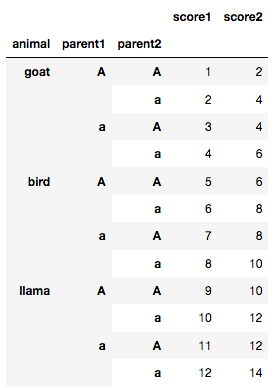

In [18]:
arrs = [['goat', 'goat', 'goat', 'goat', "bird", "bird", "bird", "bird", "llama", "llama", "llama", "llama"],
       ['A', 'A', 'a', 'a', 'A', 'A', 'a', 'a', 'A', 'A', 'a', 'a'],
       ['A', 'a', 'A', 'a', 'A', 'a', 'A', 'a', 'A', 'a', 'A', 'a']]
score_1 = list(range(1, 13))
score_2 = [2, 4, 4, 6, 6, 8, 8, 10, 10, 12, 12, 14]

animals = pd.DataFrame({'score1' : pd.Series(score_1, index = arrs),
                        'score2' : pd.Series(score_2, index = arrs)})

score1  score2
goat  A A       1       2
        a       2       4
      a A       3       4
        a       4       6
bird  A A       5       6
        a       6       8
      a A       7       8
        a       8      10
llama A A       9      10
        a      10      12
      a A      11      12
        a      12      14

## Problem 3: Working with $pandas$ DataFrames (5 points)
In this problem, you'll get practice working with $pandas$ DataFrames, reading them into and out of memory, changing their contents and performing aggregation operations.

1. Read __iris.csv__ into Python as a $pandas$ DataFrame. Note that the CSV file includes column headers. How many data points are there in this data set? What are the data types of the columns? What are the column names? The column names correspond to flower species names, as well as four basic measurements one can make of a flower: the width and length of its petals and the width and length of its sepal (the part of the pant that supports and protects the flower itself). How many species of flower are included in the data?

Answer:
1. 150 data points
2. column data types: sepal.length: float64, sepal.width: float64, petal.length: float64, petal.width: float64, species: object (string)
3. column names: Sepal.Length, Sepal.Width, Petal.Length, Petal.Width, Species
4. Number of species: 3 (setosa, versicolor, virginica)

In [21]:
iris = pd.read_csv('iris.csv')
print(iris.info())
print(iris['Species'].unique())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Sepal.Length  150 non-null    float64
 1   Sepal.Width   150 non-null    float64
 2   Petal.Length  150 non-null    float64
 3   Petal.Width   150 non-null    float64
 4   Species       150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB
None


array(['setosa', 'versicolor', 'virginica'], dtype=object)

2. The iris data is based on the data initially uploaded to the UC Irvine machine learning repository. It is now known that this data contains errors in two of its rows (see the documentation at https://archive.ics.uci.edu/ml/datasets/Iris). Using 1-indexing, these errors are in the 35th and 38th rows. The 35th row should read __4.9,3.1,1.5,0.2,"setosa"__, where the fourth feature is incorrect as it appears in the file, and the 38th row should read __4.9,3.6,1.4,0.1,"setosa"__, where the second and third features are incorrect as they appear in the file. Correct these entries of your DataFrame.

In [28]:
iris['Petal.Width'][34] = 1.5
iris['Sepal.Width'][37] = 3.6
iris['Petal.Length'][37] = 1.4

c:\users\luxau\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
c:\users\luxau\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\users\luxau\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

3. The iris dataset is commonly used in machine learning as a proving ground for clustering and classification algorithms. Some researchers have found it useful to use two additional features, called _Petal ratio_ and _Sepal ratio_, defined as the ratio of the petal length to petal width and the ratio of the sepal length to sepal width, respectively. Add two columns to your DataFrame corresponding to these two new features. Name these columns __Petal.Ratio__ and __Sepal.Ratio__, respectively.

In [31]:
iris['Petal.Ratio'] = iris['Petal.Length'] / iris['Petal.Width']
iris['Sepal.Ratio'] = iris['Sepal.Length'] / iris['Sepal.Width']

4. Save your corrected and extended DataFrame to a csv file called __iris_corrected.csv__. (This file does not need to be included in your submission.)

In [32]:
iris.to_csv('iris_corrected.csv')

5. Use a $pandas$ aggregate operation to determine the mean, median, minimum, maximum and standard deviation of the petal and sepal ratio for each of the three species in the data set. __Note:__ you should be able to get all five numbers in a single table (indeed, in a single line of code) using a well-chosen group-by or aggregate operation.

In [36]:
iris_agg = pd.DataFrame({'Petal.Ratio' : iris['Petal.Ratio'],
                       'Sepal.Ratio' : iris['Sepal.Ratio']})
iris_agg.agg([np.mean, np.median, np.min, np.max, np.std])

,Petal.Ratio,Sepal.Ratio
mean,4.267166,1.953681
median,3.292857,2.032292
amin,1.000000,1.268293
amax,15.000000,2.961538
std,2.490329,0.400480


## Problem 3: Plotting Dataframes: Major League Baseball (8 points)


__Requisite legal boilerplate:__ The information used here was obtained free of charge from and is copyrighted by Retrosheet.  Interested parties may contact [Retrosheet](www.retrosheet.org).

1. Read the data into a table called __mlb_df__. Each row of the table represents the outcome of a single game from the 2018 MLB season. Take note that the file does not have columns names; see the __header__ keyword to the __pandas.read_csv__ function. The columns are explained in a __.txt__ file which you can download from https://www.retrosheet.org/gamelogs/glfields.txt, but we will only make use of a few of them in this problem. The 10-th and 11-th columns (using 1-indexing) are the scores of the visiting and home teams, respectively. Rename these columns __v_score__ and __h_score__, respectively. MLB comprises two leagues, the American League and the National League, encoded as __AL__ and __NL__ in the table. The 5-th and 8-th columns (also 1-indexed) are the league affiliations of the visiting and home team, respectively. Rename these columns __v_league__ and __h_league__.

In [208]:
mlb_df = pd.read_csv('GL2018.txt')
mlb_df.rename(columns = {mlb_df.columns[9] : 'v_score',
                         mlb_df.columns[10] : 'h_score',
                         mlb_df.columns[4] : "v_league",
                         mlb_df.columns[7] : "h_league"}, inplace = True)

2. Create a plot with two subplots, placed side-by-side. Each subplot should be a scatter plot in which the x- and y-axes correspond to the home and visitor scores, respectively, and in which each point corresponds to a game from the season. In the left-hand plot, include all games in which both teams were in the NL, and in the right-hand plot, include all games in which both teams were in the AL. Games in which the teams were from different leagues should be ignored. Specify the transparency (cf. the __alpha__ parameter in the __matplotlib__ documentation) so that scores that occur more often will be shaded darker than rare scores. Color the points in the scatter plot according to the league affiliation of the two teams as follows: games between two teams both in the AL should be rendered as red points in the scatter plot. Games between two teams both in the NL should be rendered as blue points in the scatter plot. Label your axes and provide an appropriate title for your plot as well as its subplots. Save your plot in a pdf file called __home_vs_away_scores.pdf__. This file does not need to be including in your submission. __Note:__ you may find it useful to create an extra column in the encoding whether a given game is AL vs AL, NL vs NL or mixed.

In [209]:
import matplotlib.pyplot as plt

c:\users\luxau\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
c:\users\luxau\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


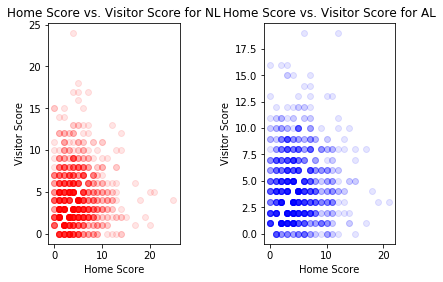

In [210]:
# Create column game_type
mlb_df['game_type'] = 'mixed'
for i in range(2430):
    if mlb_df['h_league'][i] == 'AL' and mlb_df['v_league'][i] == 'AL':
        mlb_df['game_type'][i] = 'AL'
    elif mlb_df['h_league'][i] == 'NL' and mlb_df['v_league'][i] == 'NL':
        mlb_df['game_type'][i] = 'NL'
# Find values for scatterplots
x_AL = mlb_df[mlb_df.game_type.eq('AL')].h_score
y_AL = mlb_df[mlb_df.game_type.eq('AL')].v_score
x_NL = mlb_df[mlb_df.game_type.eq('NL')].h_score
y_NL = mlb_df[mlb_df.game_type.eq('NL')].v_score
# Plot
scores = plt.figure()
plt.subplot(121)
plt.scatter(x_NL, y_NL, c = 'red', alpha = 0.1)
plt.title('Home Score vs. Visitor Score for NL')
plt.xlabel('Home Score')
plt.ylabel('Visitor Score')
plt.subplot(122)
plt.scatter(x_AL, y_AL, c = 'blue', alpha = 0.1)
plt.title('Home Score vs. Visitor Score for AL')
plt.xlabel('Home Score')
plt.ylabel('Visitor Score')
scores.savefig('home_vs_away_scores.pdf')
_ = plt.tight_layout()

3. The Skellam distribution https://en.wikipedia.org/wiki/Skellam_distribution) is the distribution that results from taking the difference between two Poisson random variables. It is often suggested as a model for the difference between scores in sports games, particularly baseball. Add a new column to the data frame called __score_diff__, given by the home score minus the away score. Make a histogram of this score difference and give the plot an appropriate title.

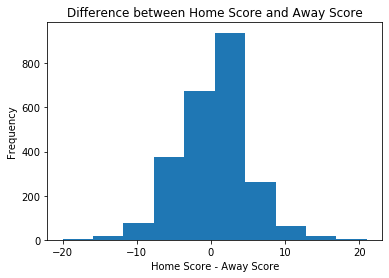

In [211]:
mlb_df['score_diff'] = mlb_df.h_score - mlb_df.v_score
n, bins, patches = plt.hist(mlb_df.score_diff)
plt.xlabel('Home Score - Away Score')
plt.ylabel('Frequency')
plt.title('Difference between Home Score and Away Score')
_ = plt.show()

4. Read the documentation about the __scipy__ implementation of the Skellam distribution at https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.skellam.html . If $\lambda_H$ and $\lambda_V$ are the means of two independent Poisson random variables $K_H$ and $K_V$, respectively, then the Skellam distribution that describes the difference $K_H - K_V$ has parameters $\lambda_H$ and $\lambda_V$. We will assume (perhaps incorrectly) that the correlation and location parameters of the Skellam distribution are both $0$. To fit a Skellam distribution to the data, we will first fit Poisson distributions to the home and away teams. Estimate parameters $\hat{\lambda}_H$ and $\hat{\lambda}_V$ as the means of the home and visitor scores, respectively. Save your estimates in variables __lambda_home__ and __lambda_visitor__, respectively.

In [212]:
import scipy.stats as scs

In [213]:
lam_h = mlb_df.h_score.mean()
lam_v = mlb_df.v_score.mean()

5. Now let's run a goodness-of-fit test to see how well the Skellam distribution matches our data. There are several ways to do this, but we will use the $\chi^2$ test, which is available in __scipy__ as __scipy.stats.chisquare__ (documentation here: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chisquare.html ). There are two problems we must address. First, the Skellam distribution predicts that sometimes $K_H = K_V$, which cannot happen in our data because ties are not allowed in baseball (play continues until a team wins https://en.wikipedia.org/wiki/Longest_professional_baseball_game), so our model should really be the Skellam distribution conditioned on the fact that $K_H \neq K_V$. Second, the $\chi^2$ test as implemented in __scipy__ requires that the observed and expected frequencies be finite-length arrays, but the Skellam distribution gives non-zero probability to every possible integer value. To account for these two issues, we will model the score difference as a Skellam distribution conditioned on the event that $K_H \neq K_V$ and $|K_H-K_V| \le 30$ ($36$ is the most runs ever scored by one team in a baseball game, so $30$ is a reasonable upper bound for our purposes). Use the __scipy__ implementation of the $\chi^2$ test to assess the fit of our model to the data (use the default delta degrees of freedom, __ddof=0__). Save the resulting p-value and the test statistic in variables named __chi2pvalue__ and __chi2stat__, respectively. Does our model agree with the data? What changes might we consider to improve the fit of our model (a few sentences will suffice here--- no need to implement any of these improvements unless you really want to)?

Answer: There is not enough evidence to suggest that the difference between scores has a different distribution than the Skellam distribution since the p-value is not great enough. To improve the fit of our model, we can optimize the lambda values to have a more accurate parameters. We could also look for and not include major outliers.

In [254]:
obs = pd.Series(mlb_df.score_diff.value_counts())
observed = pd.DataFrame({'index': obs.index,
                         'observed': obs.values})
expected = pd.DataFrame({'idx' : list(range(-30, 31))})
expected['expected'] = scs.skellam.pmf(expected.idx, lam_h, lam_v)
final = pd.merge(observed, expected, left_on='index', right_on='idx')
final.expected = final.expected*2430
del final['idx']
final['is_obs'] = final.observed >= 5
final['is_exp'] = final.expected >= 5
final = final[final.is_exp.eq(True)]
(chi2stat, chi2pvalue) = scs.chisquare(final.skellam, final.observed)